<IPython.core.display.Javascript object>


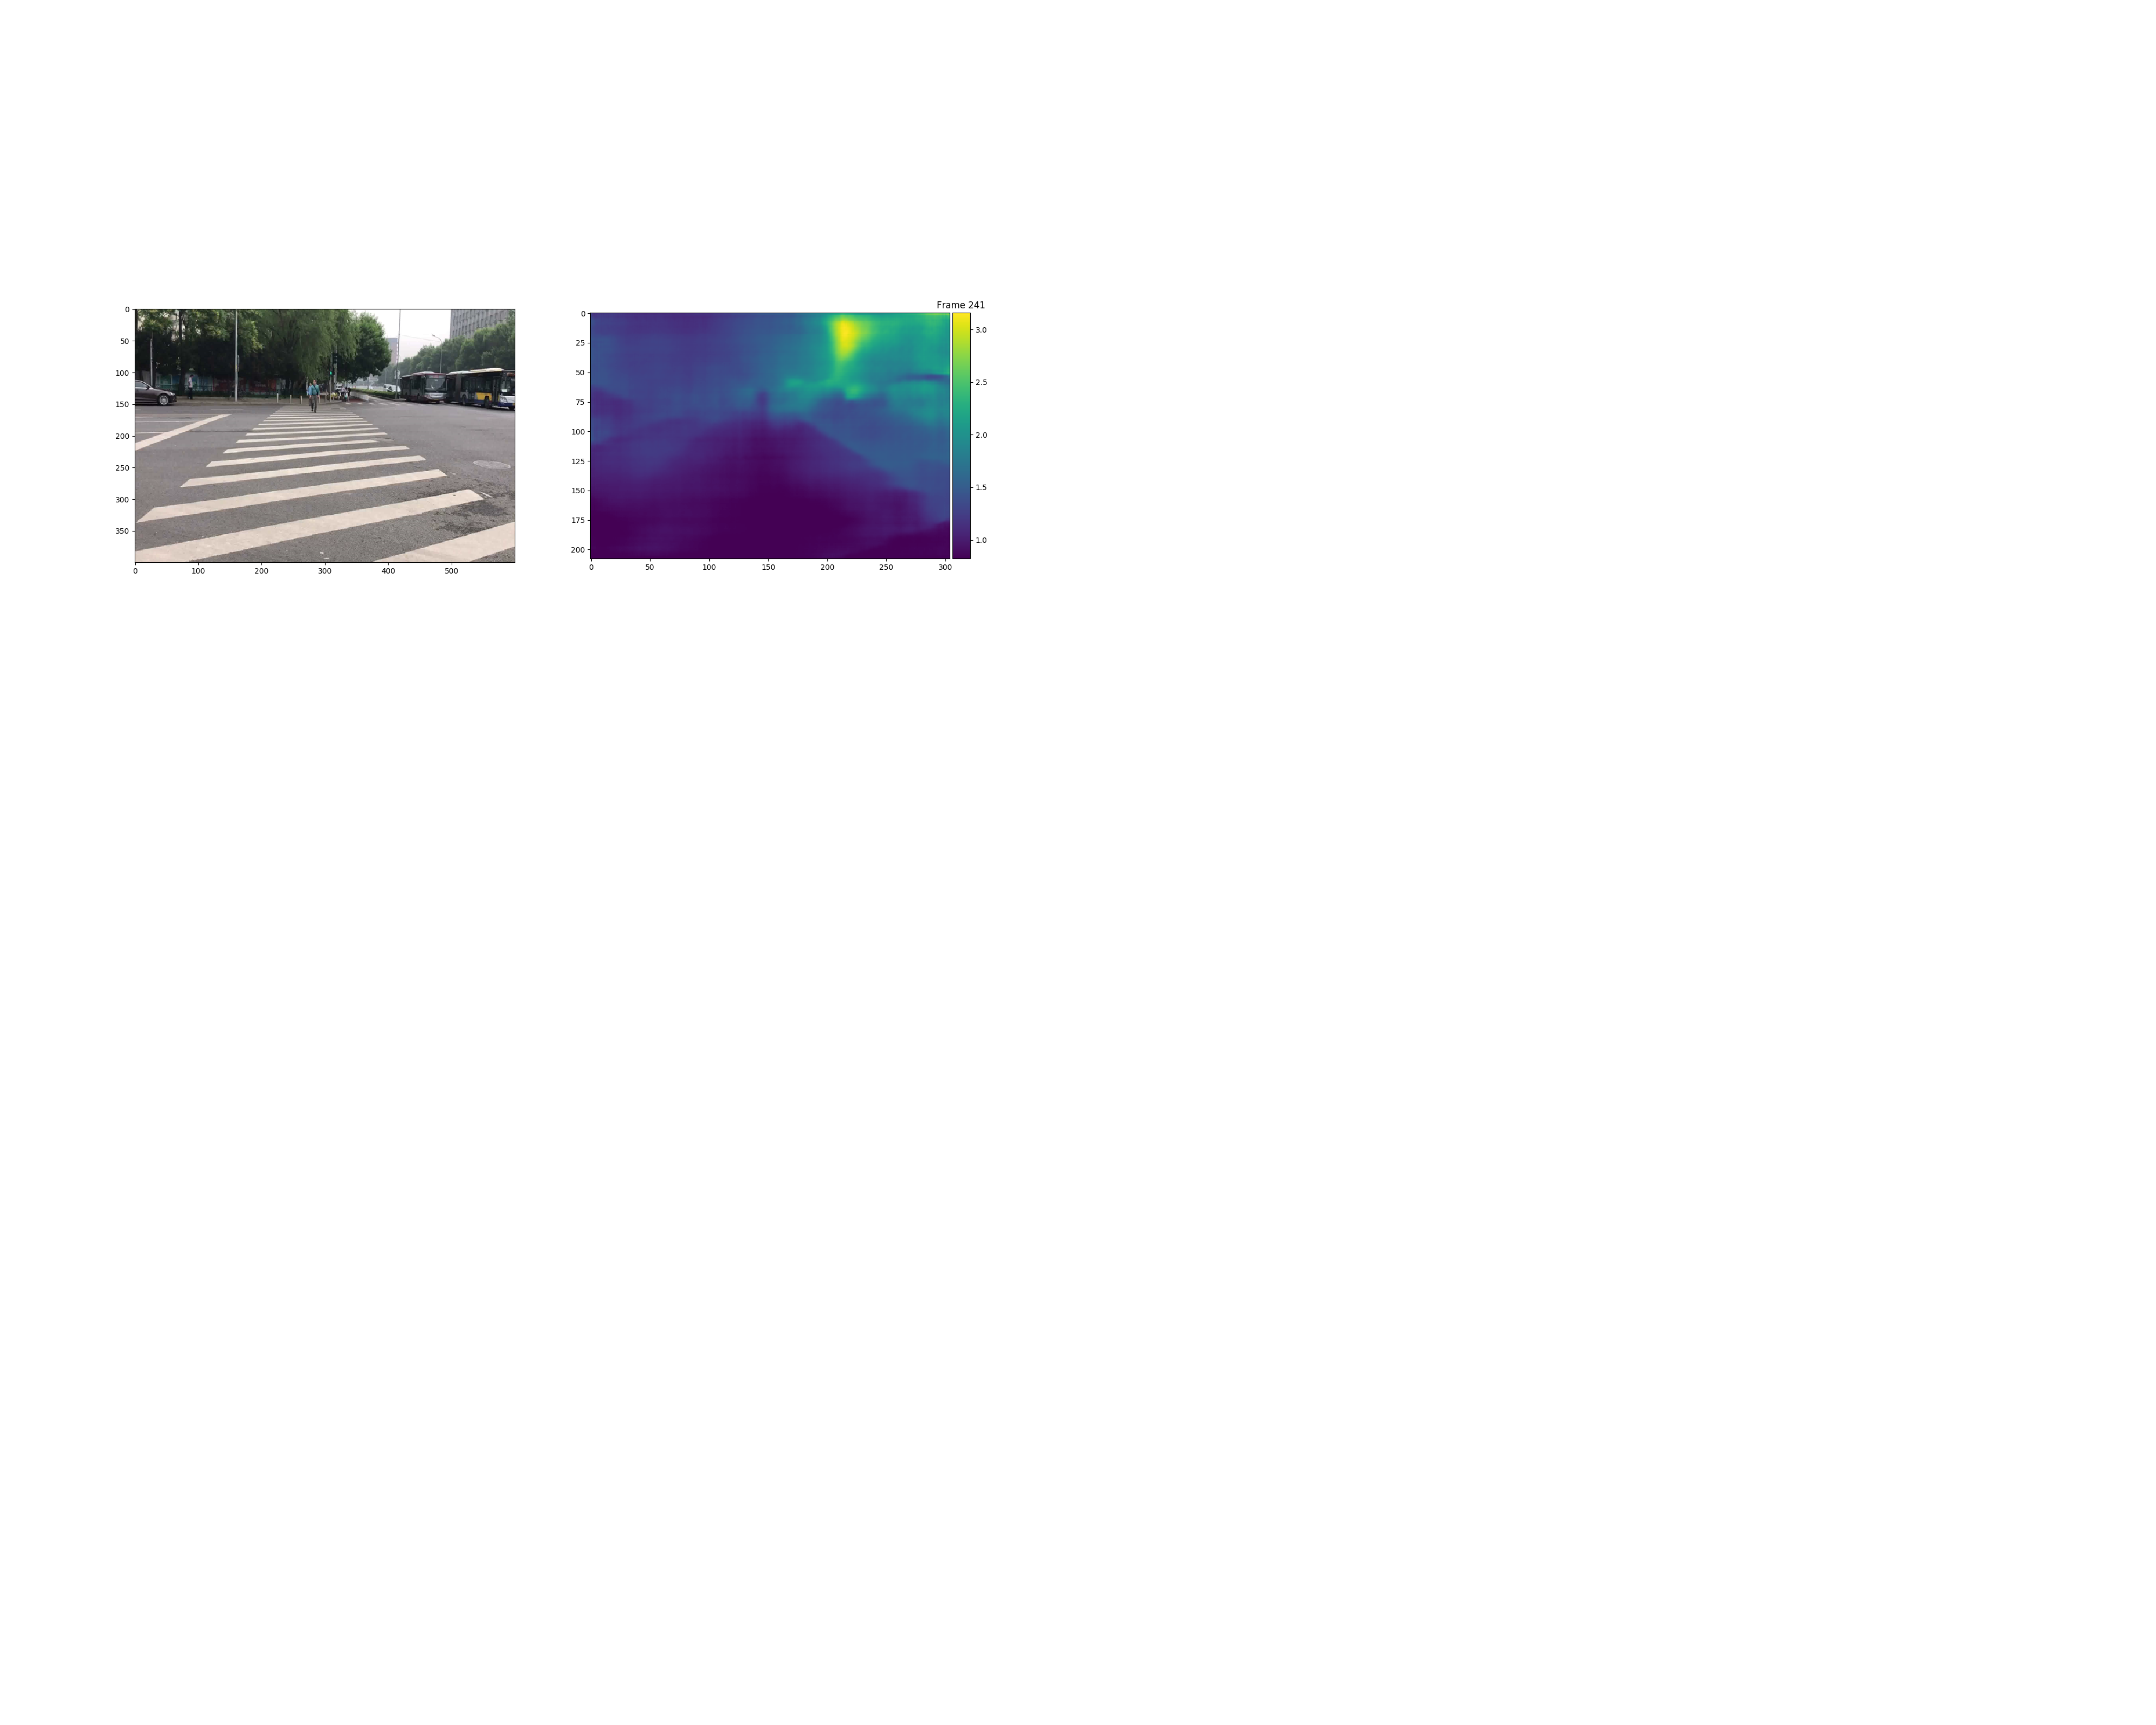

Loading the model
INFO:tensorflow:Restoring parameters from model/NYU_FCRN.ckpt
get frame 0
Loading image costs 7.035 s
Generate depth image costs 1.249 s
Draw image costs 0.505 s
get frame 1
Loading image costs 0.013 s
Generate depth image costs 0.113 s
Draw image costs 0.500 s
get frame 2
Loading image costs 0.009 s
Generate depth image costs 0.128 s
Draw image costs 0.514 s
get frame 3
Loading image costs 0.009 s
Generate depth image costs 0.110 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.416 s
get frame 6
Loading image costs 0.006 s
Generate depth image costs 0.104 s
Draw image costs 0.474 s
get frame 7
Loading image costs 0.006 s
Generate depth image costs 0.099 s
Draw image costs 0.484 s
get frame 8
Loading image costs 0.011 s
Generate depth image costs 0.107 s
Draw image costs 0.506 s
get frame 9
Loading image costs 0.010 s
Generate depth image costs 0.115 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.462 s
get frame 12
Loading image costs 0.007 s
Generate depth image costs 0.097 s
Draw image costs 0.463 s
get frame 13
Loading image costs 0.007 s
Generate depth image costs 0.098 s
Draw image costs 0.481 s
get frame 14
Loading image costs 0.007 s
Generate depth image costs 0.098 s
Draw image costs 0.442 s
get frame 15
Loading image costs 0.011 s
Generate depth image costs 0.124 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.475 s
get frame 18
Loading image costs 0.006 s
Generate depth image costs 0.098 s
Draw image costs 0.475 s
get frame 19
Loading image costs 0.007 s
Generate depth image costs 0.100 s
Draw image costs 0.478 s
get frame 20
Loading image costs 0.007 s
Generate depth image costs 0.098 s
Draw image costs 0.478 s
get frame 21
Loading image costs 0.007 s
Generate depth image costs 0.101 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.497 s
get frame 24
Loading image costs 0.011 s
Generate depth image costs 0.123 s
Draw image costs 0.477 s
get frame 25
Loading image costs 0.011 s
Generate depth image costs 0.123 s
Draw image costs 0.505 s
get frame 26
Loading image costs 0.007 s
Generate depth image costs 0.105 s
Draw image costs 0.471 s
get frame 27
Loading image costs 0.007 s
Generate depth image costs 0.099 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.477 s
get frame 30
Loading image costs 0.007 s
Generate depth image costs 0.099 s
Draw image costs 0.466 s
get frame 31
Loading image costs 0.007 s
Generate depth image costs 0.101 s
Draw image costs 0.471 s
get frame 32
Loading image costs 0.007 s
Generate depth image costs 0.099 s
Draw image costs 0.472 s
get frame 33
Loading image costs 0.007 s
Generate depth image costs 0.100 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.472 s
get frame 36
Loading image costs 0.007 s
Generate depth image costs 0.097 s
Draw image costs 0.463 s
get frame 37
Loading image costs 0.007 s
Generate depth image costs 0.101 s
Draw image costs 0.468 s
get frame 38
Loading image costs 0.006 s
Generate depth image costs 0.097 s
Draw image costs 0.471 s
get frame 39
Loading image costs 0.006 s
Generate depth image costs 0.099 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.472 s
get frame 42
Loading image costs 0.006 s
Generate depth image costs 0.098 s
Draw image costs 0.472 s
get frame 43
Loading image costs 0.007 s
Generate depth image costs 0.097 s
Draw image costs 0.471 s
get frame 44
Loading image costs 0.006 s
Generate depth image costs 0.097 s
Draw image costs 0.473 s
get frame 45
Loading image costs 0.006 s
Generate depth image costs 0.102 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.485 s
get frame 48
Loading image costs 0.007 s
Generate depth image costs 0.100 s
Draw image costs 0.627 s
get frame 49
Loading image costs 0.006 s
Generate depth image costs 0.099 s
Draw image costs 0.500 s
get frame 50
Loading image costs 0.007 s
Generate depth image costs 0.107 s
Draw image costs 0.515 s
get frame 51
Loading image costs 0.007 s
Generate depth image costs 0.106 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.497 s
get frame 54
Loading image costs 0.009 s
Generate depth image costs 0.110 s
Draw image costs 0.481 s
get frame 55
Loading image costs 0.008 s
Generate depth image costs 0.106 s
Draw image costs 0.497 s
get frame 56
Loading image costs 0.007 s
Generate depth image costs 0.105 s
Draw image costs 0.480 s
get frame 57
Loading image costs 0.012 s
Generate depth image costs 0.099 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.519 s
get frame 60
Loading image costs 0.017 s
Generate depth image costs 0.127 s
Draw image costs 0.489 s
get frame 61
Loading image costs 0.012 s
Generate depth image costs 0.112 s
Draw image costs 0.522 s
get frame 62
Loading image costs 0.008 s
Generate depth image costs 0.113 s
Draw image costs 0.541 s
get frame 63
Loading image costs 0.013 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.488 s
get frame 66
Loading image costs 0.013 s
Generate depth image costs 0.138 s
Draw image costs 0.496 s
get frame 67
Loading image costs 0.019 s
Generate depth image costs 0.122 s
Draw image costs 0.511 s
get frame 68
Loading image costs 0.018 s
Generate depth image costs 0.127 s
Draw image costs 0.508 s
get frame 69
Loading image costs 0.020 s
Generate depth image costs 0.120 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.509 s
get frame 72
Loading image costs 0.014 s
Generate depth image costs 0.106 s
Draw image costs 0.689 s
get frame 73
Loading image costs 0.016 s
Generate depth image costs 0.117 s
Draw image costs 0.502 s
get frame 74
Loading image costs 0.016 s
Generate depth image costs 0.108 s
Draw image costs 0.499 s
get frame 75
Loading image costs 0.014 s
Generate depth image costs 0.108 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.514 s
get frame 78
Loading image costs 0.013 s
Generate depth image costs 0.134 s
Draw image costs 0.513 s
get frame 79
Loading image costs 0.013 s
Generate depth image costs 0.114 s
Draw image costs 0.478 s
get frame 80
Loading image costs 0.008 s
Generate depth image costs 0.109 s
Draw image costs 0.484 s
get frame 81
Loading image costs 0.015 s
Generate depth image costs 0.142 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.490 s
get frame 84
Loading image costs 0.007 s
Generate depth image costs 0.136 s
Draw image costs 0.494 s
get frame 85
Loading image costs 0.015 s
Generate depth image costs 0.130 s
Draw image costs 0.512 s
get frame 86
Loading image costs 0.009 s
Generate depth image costs 0.111 s
Draw image costs 0.484 s
get frame 87
Loading image costs 0.009 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.518 s
get frame 90
Loading image costs 0.009 s
Generate depth image costs 0.115 s
Draw image costs 0.485 s
get frame 91
Loading image costs 0.015 s
Generate depth image costs 0.110 s
Draw image costs 0.490 s
get frame 92
Loading image costs 0.015 s
Generate depth image costs 0.110 s
Draw image costs 0.555 s
get frame 93
Loading image costs 0.013 s
Generate depth image costs 0.105 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.537 s
get frame 96
Loading image costs 0.013 s
Generate depth image costs 0.113 s
Draw image costs 0.537 s
get frame 97
Loading image costs 0.009 s
Generate depth image costs 0.118 s
Draw image costs 0.673 s
get frame 98
Loading image costs 0.016 s
Generate depth image costs 0.105 s
Draw image costs 0.520 s
get frame 99
Loading image costs 0.009 s
Generate depth image costs 0.111 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.505 s
get frame 102
Loading image costs 0.012 s
Generate depth image costs 0.111 s
Draw image costs 0.478 s
get frame 103
Loading image costs 0.008 s
Generate depth image costs 0.105 s
Draw image costs 0.480 s
get frame 104
Loading image costs 0.008 s
Generate depth image costs 0.103 s
Draw image costs 0.480 s
get frame 105
Loading image costs 0.011 s
Generate depth image costs 0.104 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.478 s
get frame 108
Loading image costs 0.011 s
Generate depth image costs 0.104 s
Draw image costs 0.481 s
get frame 109
Loading image costs 0.008 s
Generate depth image costs 0.104 s
Draw image costs 0.406 s
get frame 110
Loading image costs 0.007 s
Generate depth image costs 0.103 s
Draw image costs 0.529 s
get frame 111
Loading image costs 0.012 s
Generate depth image costs 0.116 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.540 s
get frame 114
Loading image costs 0.012 s
Generate depth image costs 0.111 s
Draw image costs 0.494 s
get frame 115
Loading image costs 0.013 s
Generate depth image costs 0.107 s
Draw image costs 0.528 s
get frame 116
Loading image costs 0.014 s
Generate depth image costs 0.113 s
Draw image costs 0.534 s
get frame 117
Loading image costs 0.015 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.524 s
get frame 120
Loading image costs 0.013 s
Generate depth image costs 0.111 s
Draw image costs 0.530 s
get frame 121
Loading image costs 0.009 s
Generate depth image costs 0.113 s
Draw image costs 0.492 s
get frame 122
Loading image costs 0.014 s
Generate depth image costs 0.108 s
Draw image costs 0.491 s
get frame 123
Loading image costs 0.012 s
Generate depth image costs 0.104 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.524 s
get frame 126
Loading image costs 0.014 s
Generate depth image costs 0.112 s
Draw image costs 0.486 s
get frame 127
Loading image costs 0.011 s
Generate depth image costs 0.109 s
Draw image costs 0.514 s
get frame 128
Loading image costs 0.011 s
Generate depth image costs 0.112 s
Draw image costs 0.502 s
get frame 129
Loading image costs 0.012 s
Generate depth image costs 0.132 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.503 s
get frame 132
Loading image costs 0.012 s
Generate depth image costs 0.105 s
Draw image costs 0.483 s
get frame 133
Loading image costs 0.014 s
Generate depth image costs 0.103 s
Draw image costs 0.503 s
get frame 134
Loading image costs 0.015 s
Generate depth image costs 0.113 s
Draw image costs 0.506 s
get frame 135
Loading image costs 0.014 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.472 s
get frame 138
Loading image costs 0.013 s
Generate depth image costs 0.104 s
Draw image costs 0.515 s
get frame 139
Loading image costs 0.013 s
Generate depth image costs 0.110 s
Draw image costs 0.472 s
get frame 140
Loading image costs 0.013 s
Generate depth image costs 0.108 s
Draw image costs 0.500 s
get frame 141
Loading image costs 0.016 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.500 s
get frame 144
Loading image costs 0.008 s
Generate depth image costs 0.113 s
Draw image costs 0.472 s
get frame 145
Loading image costs 0.009 s
Generate depth image costs 0.103 s
Draw image costs 0.483 s
get frame 146
Loading image costs 0.009 s
Generate depth image costs 0.104 s
Draw image costs 0.479 s
get frame 147
Loading image costs 0.008 s
Generate depth image costs 0.103 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.505 s
get frame 150
Loading image costs 0.008 s
Generate depth image costs 0.112 s
Draw image costs 0.508 s
get frame 151
Loading image costs 0.009 s
Generate depth image costs 0.114 s
Draw image costs 0.669 s
get frame 152
Loading image costs 0.007 s
Generate depth image costs 0.101 s
Draw image costs 0.524 s
get frame 153
Loading image costs 0.008 s
Generate depth image costs 0.111 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.496 s
get frame 156
Loading image costs 0.012 s
Generate depth image costs 0.128 s
Draw image costs 0.484 s
get frame 157
Loading image costs 0.007 s
Generate depth image costs 0.105 s
Draw image costs 0.501 s
get frame 158
Loading image costs 0.012 s
Generate depth image costs 0.128 s
Draw image costs 0.488 s
get frame 159
Loading image costs 0.007 s
Generate depth image costs 0.102 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.498 s
get frame 162
Loading image costs 0.009 s
Generate depth image costs 0.105 s
Draw image costs 0.483 s
get frame 163
Loading image costs 0.008 s
Generate depth image costs 0.101 s
Draw image costs 0.478 s
get frame 164
Loading image costs 0.008 s
Generate depth image costs 0.105 s
Draw image costs 0.479 s
get frame 165
Loading image costs 0.008 s
Generate depth image costs 0.106 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.409 s
get frame 168
Loading image costs 0.008 s
Generate depth image costs 0.104 s
Draw image costs 0.500 s
get frame 169
Loading image costs 0.009 s
Generate depth image costs 0.109 s
Draw image costs 0.473 s
get frame 170
Loading image costs 0.008 s
Generate depth image costs 0.104 s
Draw image costs 0.477 s
get frame 171
Loading image costs 0.008 s
Generate depth image costs 0.103 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.486 s
get frame 174
Loading image costs 0.008 s
Generate depth image costs 0.107 s
Draw image costs 0.527 s
get frame 175
Loading image costs 0.010 s
Generate depth image costs 0.113 s
Draw image costs 0.535 s
get frame 176
Loading image costs 0.009 s
Generate depth image costs 0.109 s
Draw image costs 0.524 s
get frame 177
Loading image costs 0.010 s
Generate depth image costs 0.131 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.493 s
get frame 180
Loading image costs 0.009 s
Generate depth image costs 0.111 s
Draw image costs 0.674 s
get frame 181
Loading image costs 0.010 s
Generate depth image costs 0.104 s
Draw image costs 0.483 s
get frame 182
Loading image costs 0.008 s
Generate depth image costs 0.105 s
Draw image costs 0.494 s
get frame 183
Loading image costs 0.008 s
Generate depth image costs 0.106 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.523 s
get frame 184
Loading image costs 0.008 s
Generate depth image costs 0.111 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.532 s
get frame 185
Loading image costs 0.008 s
Generate depth image costs 0.111 s
Draw image costs 0.524 s
get frame 186
Loading image costs 0.008 s
Generate depth image costs 0.112 s
Draw image costs 0.507 s
get frame 187
Loading image costs 0.009 s
Generate depth image costs 0.113 s
Draw image costs 0.535 s
get frame 188
Loading image costs 0.009 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.541 s
get frame 189
Loading image costs 0.010 s
Generate depth image costs 0.116 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.475 s
get frame 190
Loading image costs 0.008 s
Generate depth image costs 0.104 s
Draw image costs 0.480 s
get frame 191
Loading image costs 0.008 s
Generate depth image costs 0.104 s
Draw image costs 0.532 s
get frame 192
Loading image costs 0.010 s
Generate depth image costs 0.111 s
Draw image costs 0.482 s
get frame 193
Loading image costs 0.008 s
Generate depth image costs 0.103 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.526 s
get frame 194
Loading image costs 0.009 s
Generate depth image costs 0.114 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.507 s
get frame 195
Loading image costs 0.009 s
Generate depth image costs 0.112 s
Draw image costs 0.489 s
get frame 196
Loading image costs 0.008 s
Generate depth image costs 0.108 s
Draw image costs 0.505 s
get frame 197
Loading image costs 0.008 s
Generate depth image costs 0.113 s
Draw image costs 0.478 s
get frame 198
Loading image costs 0.007 s
Generate depth image costs 0.102 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.481 s
get frame 199
Loading image costs 0.012 s
Generate depth image costs 0.103 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.479 s
get frame 200
Loading image costs 0.008 s
Generate depth image costs 0.102 s
Draw image costs 0.519 s
get frame 201
Loading image costs 0.010 s
Generate depth image costs 0.129 s
Draw image costs 0.498 s
get frame 202
Loading image costs 0.008 s
Generate depth image costs 0.108 s
Draw image costs 0.495 s
get frame 203
Loading image costs 0.008 s
Generate depth image costs 0.104 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.485 s
get frame 204
Loading image costs 0.007 s
Generate depth image costs 0.103 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.490 s
get frame 205
Loading image costs 0.008 s
Generate depth image costs 0.107 s
Draw image costs 0.529 s
get frame 206
Loading image costs 0.009 s
Generate depth image costs 0.111 s
Draw image costs 0.742 s
get frame 207
Loading image costs 0.008 s
Generate depth image costs 0.134 s
Draw image costs 0.491 s
get frame 208
Loading image costs 0.008 s
Generate depth image costs 0.103 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.483 s
get frame 209
Loading image costs 0.007 s
Generate depth image costs 0.102 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.481 s
get frame 210
Loading image costs 0.011 s
Generate depth image costs 0.099 s
Draw image costs 0.411 s
get frame 211
Loading image costs 0.007 s
Generate depth image costs 0.101 s
Draw image costs 0.466 s
get frame 212
Loading image costs 0.009 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.491 s
get frame 213
Loading image costs 0.009 s
Generate depth image costs 0.102 s
Draw image costs 0.484 s
get frame 214
Loading image costs 0.008 s
Generate depth image costs 0.107 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.484 s
get frame 216
Loading image costs 0.009 s
Generate depth image costs 0.109 s
Draw image costs 0.476 s
get frame 217
Loading image costs 0.008 s
Generate depth image costs 0.103 s
Draw image costs 0.513 s
get frame 218
Loading image costs 0.009 s
Generate depth image costs 0.107 s
Draw image costs 0.493 s
get frame 219
Loading image costs 0.008 s
Generate depth image costs 0.111 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.482 s
get frame 220
Loading image costs 0.007 s
Generate depth image costs 0.104 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.480 s
get frame 221
Loading image costs 0.007 s
Generate depth image costs 0.102 s
Draw image costs 0.486 s
get frame 222
Loading image costs 0.007 s
Generate depth image costs 0.104 s
Draw image costs 0.482 s
get frame 223
Loading image costs 0.007 s
Generate depth image costs 0.103 s
Draw image costs 0.528 s
get frame 224
Loading image costs 0.009 s
Generate depth image costs 0.115 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.481 s
get frame 225
Loading image costs 0.008 s
Generate depth image costs 0.104 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.536 s
get frame 226
Loading image costs 0.009 s
Generate depth image costs 0.113 s
Draw image costs 0.513 s
get frame 227
Loading image costs 0.008 s
Generate depth image costs 0.112 s
Draw image costs 0.514 s
get frame 228
Loading image costs 0.008 s
Generate depth image costs 0.111 s
Draw image costs 0.506 s
get frame 229
Loading image costs 0.008 s
Generate depth image costs 0.110 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.545 s
get frame 230
Loading image costs 0.009 s
Generate depth image costs 0.113 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.540 s
get frame 231
Loading image costs 0.010 s
Generate depth image costs 0.116 s
Draw image costs 0.501 s
get frame 232
Loading image costs 0.008 s
Generate depth image costs 0.111 s
Draw image costs 0.526 s
get frame 233
Loading image costs 0.013 s
Generate depth image costs 0.113 s
Draw image costs 0.534 s
get frame 234
Loading image costs 0.010 s
Generate depth image costs 0.112 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.526 s
get frame 235
Loading image costs 0.013 s
Generate depth image costs 0.132 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.752 s
get frame 236
Loading image costs 0.012 s
Generate depth image costs 0.118 s
Draw image costs 0.482 s
get frame 237
Loading image costs 0.008 s
Generate depth image costs 0.109 s
Draw image costs 0.486 s
get frame 238
Loading image costs 0.008 s
Generate depth image costs 0.108 s
Draw image costs 0.485 s
get frame 239
Loading image costs 0.008 s
Generate depth image costs 0.106 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.539 s
get frame 240
Loading image costs 0.009 s
Generate depth image costs 0.111 s


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Draw image costs 0.516 s
get frame 241
Loading image costs 0.008 s
Generate depth image costs 0.111 s
Draw image costs 0.493 s
get frame 242
Loading image costs 0.008 s
Generate depth image costs 0.117 s


KeyboardInterrupt: 

In [1]:
%matplotlib notebook

import argparse
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from easydict import EasyDict as edict
from PIL import Image
import cv2
import time
import models

# height = 228
# width = 304
height = 800
width = 1000
channels = 3
batch_size = 1
    
def load_model():

    # Create a placeholder for the input image

    input_node = tf.placeholder(tf.float32, shape=(None, height, width, channels))
    # Construct the network

    net = models.ResNet50UpProj({'data': input_node}, batch_size, 1, False)
    return  net, input_node

def plot_image(img_ori, pred):
    fig = plt.figure()
    plt.subplot(121)
    ii = plt.imshow(img_ori, interpolation='nearest')

    plt.subplot(122)

    ax = plt.gca()
    ii = ax.imshow(pred, interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ii, cax=cax)
    plt.show()
    
def predict_image(model_data_path, image_path, net, input_node):

    
    # Default input size
    height = 228
    width = 304
   
    # Read image
    img = Image.open(image_path)
    img = img.resize([width,height], Image.ANTIALIAS)
    img_ori = img.copy() 
    img = np.array(img).astype('float32')
    img = np.expand_dims(np.asarray(img), axis = 0)

    with tf.Session() as sess:

        # Load the converted parameters
        print('Loading the model')

        # Use to load from ckpt file
        saver = tf.train.Saver()     
        saver.restore(sess, model_data_path)

        # Use to load from npy file
#         net.load(model_data_path, sess) 

        # Evalute the network for the given image
    
        pred = sess.run(net.get_output(), feed_dict={input_node: img})
        
        # Plot result
        print img.shape, pred.shape
        plot_image(img_ori, pred[0,:,:,0])
        
        return pred
        
def read_video(filename):
    cap = cv2.VideoCapture(filename)
    i = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        print('get frame %d'%i)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
        yield frame
        i+=1

    cap.release()

def predict_video(model_data_path, video_path, net, input_node):

    
    # Default input size

    fig = plt.figure(figsize=(20, 16))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    timestamps = [time.time()]
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        print('Loading the model')

        saver = tf.train.Saver()     
        saver.restore(sess, model_data_path)
        for i, data in enumerate(read_video(video_path)):
            timestamps.append(time.time())

            print('Loading image costs %.3f s'%(timestamps[-1] - timestamps[-2]))
            # Read image
    #         img = Image.open(image_path)

    #         import pdb
    #         pdb.set_trace()
            img = Image.fromarray(data, 'RGB')
            img = img.resize([width,height], Image.ANTIALIAS)
            img_ori = img.copy()

            img = np.array(img).astype('float32')
            img = np.expand_dims(np.asarray(img), axis = 0)

            # Evalute the network for the given image
            pred = sess.run(net.get_output(), feed_dict={input_node: img})
#             out = np.zeros((height, width * 2, 3), dtype=np.uint8)
#             out[:height,:width,:] = img_ori
            npic = pred[0, :, :, 0]
            timestamps.append(time.time())
            print('Generate depth image costs %.3f s'%(timestamps[-1] - timestamps[-2]))
#             npic = cv2.resize(pred[0, :, :, 0], (width, height), interpolation=cv2.INTER_CUBIC)
#             npic = np.minimum(pic / 10 * 255, 255).astype(np.uint8)
#             out[:height,width:, 0] = npic
#             out[:height,width:, 1] = npic
#             out[:height,width:, 2] = npic

            # Plot result
            ax1.imshow(img_ori)
            ii = ax2.imshow(npic)
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            bar = plt.colorbar(ii, cax=cax)
            plt.title('Frame %d'%i)

            fig.canvas.draw()
            ax1.clear()
            ax2.clear()
            bar.remove()
            timestamps.append(time.time())
            print('Draw image costs %.3f s'%(timestamps[-1] - timestamps[-2]))
    
def main():
    # Parse arguments
#     parser = argparse.ArgumentParser()
#     parser.add_argument('model_path', help='Converted parameters for the model')
#     parser.add_argument('image_paths', help='Directory of images to predict')
#     args = parser.parse_args()
    args = edict()
    tf.reset_default_graph()
    args.model_path = 'model/NYU_FCRN.ckpt'
    args.image_paths = 'images/test3.jpg'
    args.video_paths = 'images/IMG_1052.avi'

    # Predict the image
    net, input_node = load_model()
#     pred = predict_image(args.model_path, args.image_paths, net, input_node)
    pred = predict_video(args.model_path, args.video_paths, net, input_node)
#     os._exit(0)

if __name__ == '__main__':
    main()

        





In [ ]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))